### MCMC pour déterminer les paramètres du modèle hydraulique

📌 Objectif du MCMC :

	•Simuler plusieurs milliers de scénarios réalistes en échantillonnant ces distributions.
	•Calculer à chaque simulation la hauteur d’eau  H  et la surverse  S .
	•Extraire des statistiques utiles (médiane, moyenne, intervalle de confiance) 

| Paramètre                        | Loi de probabilité mentionnée                                      |
|----------------------------------|------------------------------------------------------------------|
| Débit Q                   | Loi triangulaire (Q_min, Q_mode, Q_max)     |
| Coefficient de Strickler K_s | Loi triangulaire (K_s,min, K_s,mode, K_s,max) |
| Hauteur de la digue h_d    | Constante (pas mentionnée comme incertaine)                     |
| Cote du fond en amont Z_m et en aval Z_v | Constante (non explicitement mentionnée comme incertaine) |

### 📂 Importation des données & librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
sns.set_style("whitegrid")
np.random.seed(42)

In [3]:
L = 5000 
B = 300   
hd = 5.50 # Hauteur de la digue issue de l'étude des crues historiques
Zb = 50
N = 5000 # Arbitraire

Q_samples = np.zeros(N)
Ks_samples = np.zeros(N)
Zv_samples = np.zeros(N)
Zm_samples = np.zeros(N)
H_samples = np.zeros(N)
S_samples = np.zeros(N)

# Conditions initiales posées arbitrairement
Q_samples[0] = 1013  
Ks_samples[0] = 30   
Zv_samples[0] = 50   
Zm_samples[0] = 55 

Définitions de mes lois 

In [4]:
def gumbel_pdf(x, mode=1013, beta=558):
    return (1/beta) * np.exp(-(x - mode) / beta) * np.exp(-np.exp(-(x - mode) / beta))

def normal_pdf(x, mu=30, sigma=7.5):
    return (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)

def triangular_pdf(x, lower, upper, mode):
    if lower <= x <= mode:
        return 2 * (x - lower) / ((upper - lower) * (mode - lower))
    elif mode < x <= upper:
        return 2 * (upper - x) / ((upper - lower) * (upper - mode))
    else:
        return 0

$$H = \left( \frac{Q}{K_s \sqrt{\frac{Z_m - Z_v}{L} B}} \right)^{\frac{3}{5}}$$

$$S = Z_v + H - h_d - Z_b$$

# Simulation MCMC

À chaque itération, des valeurs de $Q$, $K_s$, $Z_v$ et $Z_m$ sont tirées en respectant leurs distributions de probabilité.  
Ces valeurs sont ensuite utilisées pour calculer $H$ et $S$.

- À chaque étape, de nouvelles valeurs aléatoires de $Q$, $K_s$, $Z_v$ et $Z_m$ sont proposées.  
- Ces valeurs sont acceptées ou rejetées en fonction de leur probabilité d’occurrence.  
- Ce processus est répété un grand nombre de fois afin d'obtenir une distribution complète de $H$ et $S$.

In [5]:
# Metropolis-Hastings
for i in range(1, N):

    Q_prop = max(0.1, np.random.normal(Q_samples[i-1], 50))  
    Ks_prop = max(0.1, np.random.normal(Ks_samples[i-1], 2))
    Zv_prop = np.random.normal(Zv_samples[i-1], 0.5)
    Zm_prop = max(Zv_prop + 0.1, np.random.normal(Zm_samples[i-1], 0.5))  # Assure Zm > Zv

    alpha_Q = min(1, gumbel_pdf(Q_prop) / gumbel_pdf(Q_samples[i-1]))
    alpha_Ks = min(1, normal_pdf(Ks_prop) / normal_pdf(Ks_samples[i-1]))
    alpha_Zv = min(1, triangular_pdf(Zv_prop, 49, 51, 50) / triangular_pdf(Zv_samples[i-1], 49, 51, 50))
    alpha_Zm = min(1, triangular_pdf(Zm_prop, 54, 56, 55) / triangular_pdf(Zm_samples[i-1], 54, 56, 55))

    Q_samples[i] = Q_prop if np.random.rand() < alpha_Q else Q_samples[i-1]
    Ks_samples[i] = Ks_prop if np.random.rand() < alpha_Ks else Ks_samples[i-1]
    Zv_samples[i] = Zv_prop if np.random.rand() < alpha_Zv else Zv_samples[i-1]
    Zm_samples[i] = Zm_prop if np.random.rand() < alpha_Zm else Zm_samples[i-1]

    # H
    delta_Z = max(0.001, Zm_samples[i] - Zv_samples[i])  # Empêche une valeur négative
    H_samples[i] = (Q_samples[i] / (Ks_samples[i] * np.sqrt(delta_Z / L) * B)) ** (3/5)


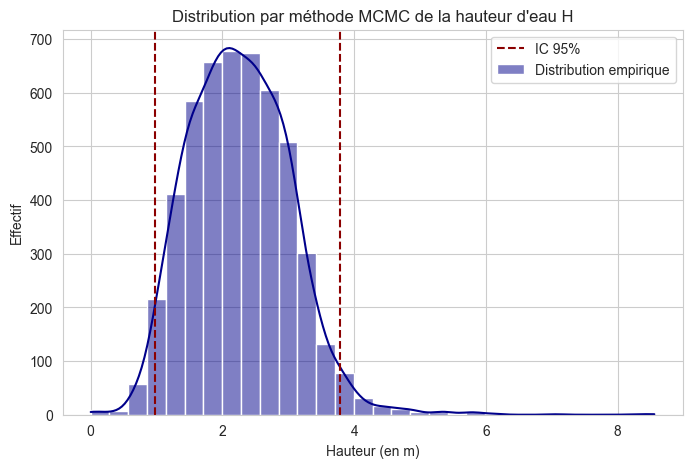

In [6]:
H_lower, H_upper = np.percentile(H_samples, [2.5, 97.5])

plt.figure(figsize=(8,5))
sns.histplot(H_samples, kde=True, bins=30, label="Distribution empirique", color="darkblue")
plt.axvline(H_lower, color="darkred", linestyle="dashed", label="IC 95%")
plt.axvline(H_upper, color="darkred", linestyle="dashed")
plt.xlabel("Hauteur (en m)")
plt.ylabel("Effectif")
plt.legend()
plt.title("Distribution par méthode MCMC de la hauteur d'eau H")
plt.show()


🔹 Résultats de l’optimisation de la digue 🔹
    hd (en m)  P(S > 0)
0         0.0    0.9986
1         0.5    0.9834
2         1.0    0.9250
3         1.5    0.8042
4         2.0    0.6036
5         2.5    0.3802
6         3.0    0.1962
7         3.5    0.0772
8         4.0    0.0254
9         4.5    0.0086
10        5.0    0.0046
11        5.5    0.0026
12        6.0    0.0016
13        6.5    0.0006
14        7.0    0.0006
15        7.5    0.0006
16        8.0    0.0004
17        8.5    0.0004
18        9.0    0.0002
19        9.5    0.0000

✅ Hauteur optimale de la digue : 3.50 m (où P(S > 0) < 10%)

✅ Hauteur optimale de la digue : 4.50 m (où P(S > 0) < 1%)


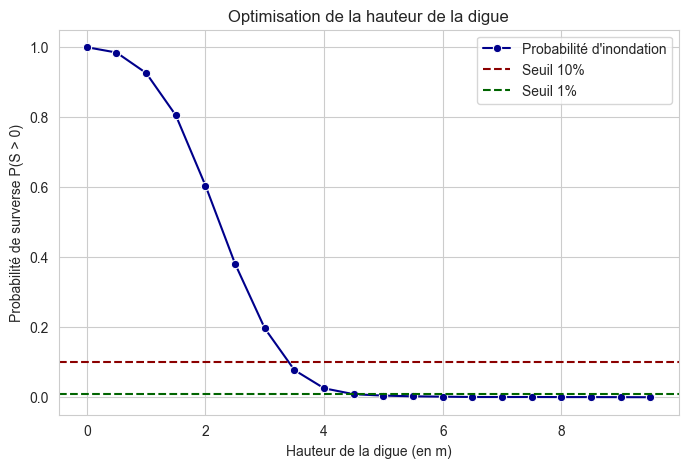

In [7]:
hd_values = np.arange(0, 10, 0.5)  
seuil_1 = 0.1
seuil_2 = 0.01

# Probabilité d'inondation pour chaque hauteur de digue
P_inondation_hd = []
for hd_test in hd_values:
    S_samples = Zv_samples + H_samples - hd_test - Zb
    P_inondation = np.mean(S_samples > 0)
    P_inondation_hd.append(P_inondation)

df_hd_optimal = pd.DataFrame({
    "hd (en m)": hd_values,
    "P(S > 0)": P_inondation_hd
})

# Trouver la plus petite hauteur où P(S > 0) < seuil
optimal_hd_index_1 = next((i for i, p in enumerate(P_inondation_hd) if p < seuil_1), None)
optimal_hd_1 = hd_values[optimal_hd_index_1] if optimal_hd_index_1 is not None else None

optimal_hd_index_2 = next((i for i, p in enumerate(P_inondation_hd) if p < seuil_2), None)
optimal_hd_2 = hd_values[optimal_hd_index_2] if optimal_hd_index_2 is not None else None

print("\n🔹 Résultats de l’optimisation de la digue 🔹")
print(df_hd_optimal)
if optimal_hd_1:
    print(f"\n✅ Hauteur optimale de la digue : {optimal_hd_1:.2f} m (où P(S > 0) < {seuil_1:.0%})")
else:
    print("✅ Toutes les hauteurs testées sont suffisantes (P(S > 0) = 0)")

if optimal_hd_1:
    print(f"\n✅ Hauteur optimale de la digue : {optimal_hd_2:.2f} m (où P(S > 0) < {seuil_2:.0%})")
else:
    print("✅ Toutes les hauteurs testées sont suffisantes (P(S > 0) = 0)")


plt.figure(figsize=(8,5))
# Tracé de la courbe
sns.lineplot(x=hd_values, y=P_inondation_hd, marker='o', label="Probabilité d'inondation", color="darkblue")

# Ligne horizontale pour le seuil 1%
plt.axhline(y=seuil_1, linestyle='--', label=f"Seuil {seuil_1:.0%}", color="darkred")
plt.axhline(y=seuil_2, linestyle='--', label=f"Seuil {seuil_2:.0%}", color="darkgreen")

# Personnalisation des axes et du titre
plt.xlabel("Hauteur de la digue (en m)")
plt.ylabel("Probabilité de surverse P(S > 0)")
plt.title("Optimisation de la hauteur de la digue")

plt.legend()
plt.show()